In [1]:
import torch
import torchvision
from torchvision.datasets.utils import download_url
import pandas as pd
import librosa
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, random_split
import librosa.display
import matplotlib.pyplot as plt
import tarfile
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Loading the metadata
df=pd.read_csv("data/sound.csv")
df
classes=list(df["Class"].unique())
classes

['dog_bark',
 'children_playing',
 'car_horn',
 'air_conditioner',
 'street_music',
 'gun_shot',
 'siren',
 'engine_idling',
 'jackhammer',
 'drilling']

In [3]:
paths=dict()
for i in range(len(classes)):
    temp_df=df[df["Class"]==classes[i]].reset_index()
    fold=temp_df["Folder_no"].iloc[0]    # The fold of the first audio sample for the specific class
    sample_name=temp_df["File_name"].iloc[0]
    path="data//audio/fold{0}/{1}".format(fold, sample_name)
    paths[classes[i]]=path
paths

{'dog_bark': 'data//audio/fold5/100032-3-0-0.wav',
 'children_playing': 'data//audio/fold5/100263-2-0-117.wav',
 'car_horn': 'data//audio/fold10/100648-1-0-0.wav',
 'air_conditioner': 'data//audio/fold5/100852-0-0-0.wav',
 'street_music': 'data//audio/fold7/101848-9-0-0.wav',
 'gun_shot': 'data//audio/fold1/102305-6-0-0.wav',
 'siren': 'data//audio/fold7/102853-8-0-0.wav',
 'engine_idling': 'data//audio/fold10/102857-5-0-0.wav',
 'jackhammer': 'data//audio/fold1/103074-7-0-0.wav',
 'drilling': 'data//audio/fold3/103199-4-0-0.wav'}

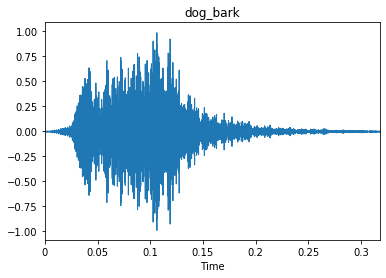

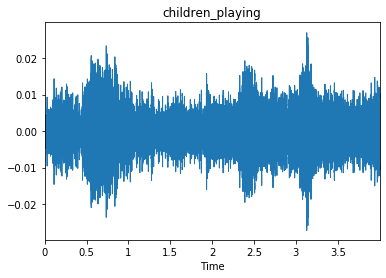

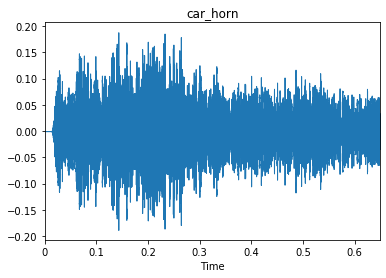

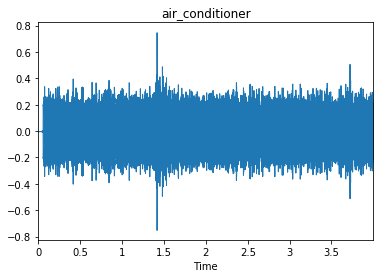

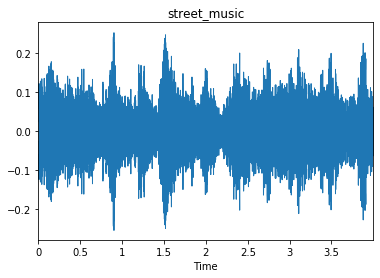

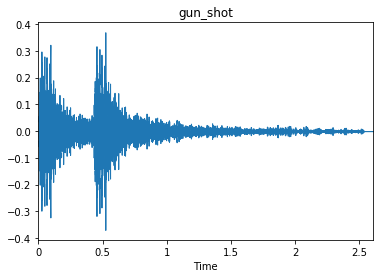

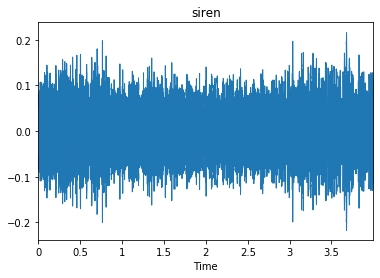

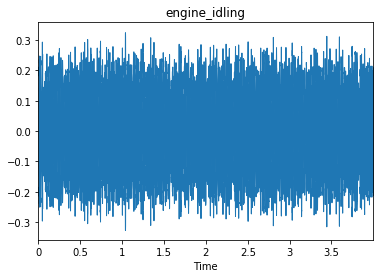

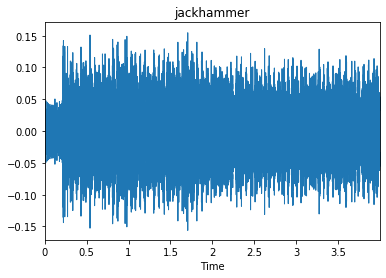

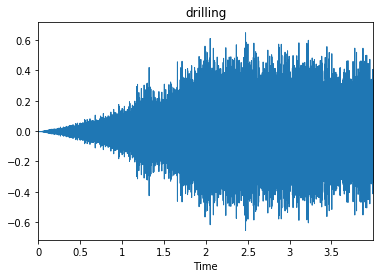

In [4]:
# Output waveplots for single files from each classes
for i, label in enumerate(classes):
    sample=paths[label]
    plt.clf()
    plt.title(label)
    data, sample_rate=librosa.load(sample)
    librosa.display.waveplot(data, sr=sample_rate)
    plt.show()

For audio samples, one of the main features involved is the power spectrum. One type of 
power specturm is called the Mel Frequency Cepstrum We calculate the coefficients for Mel
Frequency Cepstrum (MFCC) using librosa Lets extract the MFCCs for a single audio sample as an example.

In [5]:
# We can decide how many mfccs are required for each sample. Here I chose 40 coefficients.
path=paths["drilling"]
audio, sr=librosa.load(path)
mfccs=librosa.feature.mfcc(audio, sr, n_mfcc=40)
mfccs.shape

(40, 173)

In [6]:
# To use a vector of features for each audio sample, we take the mean of the mffcs for each #frame of the sample.

def extract_mfcc(path):
    audio, sr=librosa.load(path)
    mfccs=librosa.feature.mfcc(audio, sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)

In [7]:
# Let’s convert all the audio samples into numeric datafeatures=[]
features=[]
labels=[]
folds=[]
for i in range(len(df)):
    fold=df["Folder_no"].iloc[i]
    filename=df["File_name"].iloc[i]
    path="data/audio/fold{0}/{1}".format(fold, filename)
    #path="data//audio/fold{0}/{1}".format(fold, sample_name)
    mfccs=extract_mfcc(path)
    
    features.append(mfccs)
    folds.append(fold)
    labels.append(df["ID"].iloc[i])

/home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
/home/msc1/anaconda3/envs/Env-7146COMP/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [8]:
# Converting the features and labels to a tensor dataset

features=torch.tensor(features)
features
labels=torch.tensor(labels)
labels
folds=torch.tensor(folds)
folds

tensor([5, 5, 5,  ..., 7, 7, 7])

In [9]:
# Saving the dataset to disk to prevent re-Loading
torch.save(features, "data/features_mfccs.pt")
torch.save(labels, "data/labels.pt")
torch.save(folds, "data/folds.pt")

In [10]:
# Re accessing the features, labels, folds from the saved_files

features=torch.load("data/features_mfccs.pt")
labels=torch.load("data/labels.pt")
folds=torch.load("data/folds.pt")

In [11]:
def get_dataset(skip_fold):
    local_features=[]
    local_labels=[]
    for i in range(len(folds)):
        if folds[i]==skip_fold:
            continue
        local_features.append(features[i])
        local_labels.append(labels[i])
    local_features=torch.stack(local_features)
    local_labels=torch.stack(local_labels)
    return TensorDataset(local_features, local_labels)

In [12]:
# Initialize the dataset
dataset=get_dataset(skip_fold=10)
len(dataset)

7895

In [13]:
# Let's split the training data into trainig and validation data
val_size=int(0.1*len(dataset))
train_size=len(dataset)-val_size

train_ds, val_ds=random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(7106, 789)

In [14]:
# Will initialize the data loader for train and validation
batch_size=128
train_loader=DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader=DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [15]:
# Looking at a batch of data
for x,y in train_loader:
    print(f"feautres: {x}\nlabels: {y}")
    print(f"dtypes: (x)->{x.dtype}, (y)->{y.dtype}")
    break

feautres: tensor([[-3.1611e+02,  1.4337e+02, -2.1268e+01,  ...,  1.3946e+00,
         -1.5867e+00,  1.4888e+00],
        [-2.9335e+02,  1.7411e+02, -3.3509e+01,  ..., -1.0463e-02,
         -3.5801e+00,  8.8708e-01],
        [-9.7115e+01,  1.5649e+02, -7.4488e+00,  ...,  9.9251e-01,
         -1.4588e+00,  1.4596e+00],
        ...,
        [-1.2799e+02,  1.0265e+02, -3.4207e+01,  ..., -6.7466e+00,
         -5.3834e+00,  1.0762e+01],
        [-3.0612e+02,  2.4204e+01,  5.6835e+00,  ..., -3.5516e-02,
         -1.8320e+00, -6.3525e-01],
        [-7.0158e+02,  1.3101e+02,  6.4212e+00,  ..., -3.6723e+00,
         -5.0405e-01,  1.0855e+00]])
labels: tensor([2, 8, 5, 1, 2, 7, 2, 4, 5, 5, 4, 3, 6, 3, 2, 8, 4, 2, 2, 0, 4, 3, 8, 7,
        6, 0, 5, 7, 1, 3, 6, 7, 3, 7, 0, 0, 2, 7, 9, 6, 2, 2, 2, 8, 7, 5, 7, 5,
        9, 9, 8, 5, 4, 9, 5, 3, 9, 9, 2, 4, 1, 5, 8, 0, 2, 5, 3, 9, 9, 8, 3, 5,
        2, 7, 9, 7, 3, 5, 5, 7, 5, 2, 7, 0, 7, 0, 4, 5, 4, 3, 8, 4, 3, 6, 7, 5,
        9, 3, 9, 2, 9, 4, 6, 1

In [16]:
# Will defin a function that calculates the accuracy of predictions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
# Defining the model
class AudioClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

In [18]:
# Defining the models
input_size=40   # Since we're generating 40 mfccs, the number of input features is 40
output_size=10
class sound_model1(AudioClassificationBase):
    def __init__(self):
        super().__init__()
        self.network=nn.Sequential(
            nn.Linear(input_size,128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64,output_size),
            nn.Sigmoid()
        )

    def forward(self, x_batch):
        return self.network(x_batch)
    
model1=sound_model1()

In [19]:
# Defining functions to plot losses and accuracies over time

def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs')

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [20]:
# Defining a function to get the default device, i.e, CPU or GPU

def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

device=get_default_device()
device

device(type='cuda')

In [21]:
# Function to move data to the chosen default device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [22]:
# Defining an instance that moves all the tensors (DataLoaders) into the default device
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [23]:
# Moving the data to the device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [24]:
def evaluate(model, val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def train(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, print_loss=True):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        with torch.no_grad():
            result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        # model.epoch_end(epoch, result)
        history.append(result)
        if print_loss:
            print(f"Epoch [{epoch}]: Validation loss -> {result['val_loss']}, Validation accuracy -> {result['val_acc']}")
    return history

In [25]:
# Initializing the model and moving it to the GPU
model1=sound_model1()
model1
# Moving the model to the GPU
to_device(model1, device)

sound_model1(
  (network): Sequential(
    (0): Linear(in_features=40, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Sigmoid()
  )
)

In [26]:
history1=[evaluate(model1, val_loader)]
history1

[{'val_loss': 2.408247709274292, 'val_acc': 0.14105017483234406}]

In [32]:
# Begin training the model. Feel free to change the number of epochs and the learning rate.

epochs=50
lr=0.01
history1=train(epochs, lr, model1, train_loader, val_loader)

Epoch [0]: Validation loss -> 1.8291270732879639, Validation accuracy -> 0.5226934552192688
Epoch [1]: Validation loss -> 1.8472795486450195, Validation accuracy -> 0.5069621801376343
Epoch [2]: Validation loss -> 1.839088797569275, Validation accuracy -> 0.531622052192688
Epoch [3]: Validation loss -> 1.8311452865600586, Validation accuracy -> 0.5270514488220215
Epoch [4]: Validation loss -> 1.8368154764175415, Validation accuracy -> 0.5293899178504944
Epoch [5]: Validation loss -> 1.8276951313018799, Validation accuracy -> 0.5293899178504944
Epoch [6]: Validation loss -> 1.828795075416565, Validation accuracy -> 0.5327380895614624
Epoch [7]: Validation loss -> 1.8305046558380127, Validation accuracy -> 0.5372024178504944
Epoch [8]: Validation loss -> 1.8223011493682861, Validation accuracy -> 0.5339604616165161
Epoch [9]: Validation loss -> 1.8176090717315674, Validation accuracy -> 0.5372024178504944
Epoch [10]: Validation loss -> 1.8228540420532227, Validation accuracy -> 0.5416666

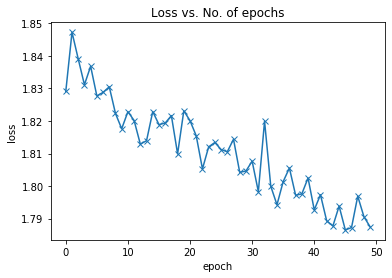

In [33]:
plot_losses(history1)

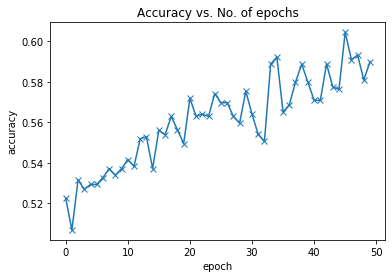

In [34]:
plot_accuracies(history1)